In [1]:
# Import standard python libraries
import os
import pandas as pd
import numpy as np
# Import plotting functions
import matplotlib.pyplot as plt
import seaborn as sb
# Import file readers
import csv
# Import data analyzation metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [2]:
# A computer scientist can adjust these metrics to change the number of significant features used 
# in calculation and change the number of features used

# The number of features to work with, does not include feature label
k_best_feats = 6

# The number of bins to discretize each feature 
num_of_bins = 6

# The name of the target column
target_label = 'Label'

# The name of the data csv in the input folder
email_names_csv = 'spambasenames.csv'

# The name of the column names csv in the input folder
email_csv = 'spambase.csv'

In [3]:
# Import a working path directory
directory = os.getcwd()
# Connect with input directory
input_directory = os.path.join(directory, 'input')
# Connect names to a data frame
names_path = os.path.join(input_directory, email_names_csv)

# Get the names of features from the csv file
features = pd.read_csv(names_path)
feature_names = features.columns
spam_names = features.copy() 

# Append an extra column to hold the target feature
spam_names[target_label] = []
# Save the names as a list
col_names = spam_names.columns
# Create an email data frame with the given name columns
data_path = os.path.join(input_directory, email_csv)

# Create a data frame w/ spam base data set with the col names
email_data = pd.read_csv(data_path, header=None, names=col_names, index_col=False)

In [4]:
# PART 2A:  Read the input in the input directory and do the test_train split within the notebook

# Shuffle positive and negative data sets
df_shuffled=email_data.iloc[np.random.permutation(email_data.index)].reset_index(drop=True)

# Split dataset into training set and test set.
X_train, X_test, y_train, y_test = train_test_split(df_shuffled[feature_names], df_shuffled[target_label], test_size=0.3, random_state=1) # 70% training and 30% test

In [5]:
# PART 2B: Preprocess any data more than what you needed to do in part 1 for your own implementation of 
# naïve bayes. Any assumptions should be documented here.

# Select the k best features for predicting the word as determined by SelectKBest and chi2
best_features = SelectKBest(chi2, k=k_best_feats)
fit = best_features.fit(X_train, y_train)
# Fit the features to their score
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_test.columns)

# Concatenate the two dataframes for a better visualization 
feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
feature_scores.columns = ['Specs','Score']  # naming the dataframe columns
best_features = feature_scores.nlargest(k_best_feats,'Score')['Specs'].values.tolist()

# Make a new training model and test model with the best features
new_X_train = X_train.copy()[best_features]
new_X_test = X_test.copy()[best_features]
    
# Discretize the values in the train set as intervals
for feat in best_features:
    new_X_train[feat] = pd.qcut(new_X_train[feat], num_of_bins, duplicates='drop')

In [6]:
# Make a dictionary which keeps the intervals of each discrete value in train set so we can 
# equally discretize the test set
dict_names = {}
for feat in new_X_train:
    interval_list = pd.unique(new_X_train[feat]).tolist() 
    dict_names[feat] = interval_list
    for i in range(len(dict_names.get(feat))):
        new_X_train[feat] = new_X_train[feat].replace([dict_names.get(feat)[i]],i)
        dict = dict_names

In [7]:
# Select k features for the test set
X_test = X_test[best_features]
feat_list = X_test.columns.tolist()

# Discretize the test set into the same intervals that qcut assigned each discrete value 
# in the train set
for index, row in X_test.iterrows():
    for feat in feat_list:
        #print("feat",feat)
        # Get the info of the cell we want
        num = X_test[feat][index]
        #print("num",num)
        interval = dict_names[feat]
        #print("list", interval)
        interval_len = len(interval)
        #print("list length", interval_len)
        is_found = False
        # Check which interval the data is in
        for i in range(interval_len):
            if num in interval[i]:
                X_test[feat][index] = i
                is_found = True
        # If the number is too large for our intervals, assign it to the largest interval
        if is_found == False:
            max_interval = interval[0]
            max_interval_index = 0
            for j in range(interval_len):
                if interval[j] > max_interval:
                    max_interval_index = j
                    max_interval = interval[j]
            X_test[feat][index] = max_interval_index

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
# PART 2C: Code to implement naïve bayes with any exception handling. 
# Any parameters considered important should be passed to the function call such that 
# parameter tuning can be done by the data scientist while trying your function.

# Important parameters: a training x set, a training y set, and to calculate probabilities
# we must have a test x. Additionally, computer scientists can adjust the alpha in my algorithm
# passing in the x and y test during fit. 
class NaiveBayes:

    def __init__(self):
        self.X = None
        self.Y = None
        self.prob_df = None
        self.ham_prob = 0
        self.spam_prob = 0
        self.alpha = 1
    
    def fit(self, x_test_set, y_test_set, offset=1):
        self.X = x_test_set
        self.Y = y_test_set
        self.alpha = offset
        self.make_frame()
        self.seperate_emails()
        
    def make_frame(self):
        rows_list = []
        for key, value in dict_names.items():
            val = key
            for i in range(len(value)):
                feat_name = val + str(i)
                rows_list.append(feat_name)
        self.prob_df = pd.DataFrame(columns = rows_list)
    
    def seperate_emails(self):
        # Concatenate train and test set back together
        train_set = pd.concat([self.X, self.Y], axis=1)
        
        # Make a ham and spam set to calculate their own probabilities
        ham_set = train_set.loc[train_set[target_label] == 0]
        spam_set = train_set.loc[train_set[target_label] == 1]
        # Calculate the instances of spam and ham
        ham_rows = ham_set.shape[0]
        spam_rows = spam_set.shape[0]
        self.ham_prob = ham_rows / self.X.shape[0]
        self.spam_prob = spam_rows / self.X.shape[0]

        # Drop the label off feature df's now
        ham_x = ham_set.drop(columns=target_label)
        spam_x = spam_set.drop(columns=target_label)
        # Calculate the probabilities for each word in the df
        self.calc_probs(ham_x, ham_rows, 0)
        self.calc_probs(spam_x, spam_rows, 1)

    def calc_probs(self, x_set, rows, is_spam):
        row_list = []
        # Calculate the probability of each interval in the dataset
        for feat in x_set:
            # See how many unique features are in the col
            bin_num = len(dict_names[feat])
            chance = 0
            for i in range(bin_num):
                # Get the interval
                interval = dict_names[feat][i]
                # Calculate the number of occurrences of the interval
                occurrences = x_set[feat].value_counts().iloc[i]
                # Calculate the probability of the interval
                chance = ((occurrences + self.alpha) / (rows + (self.alpha * bin_num)))
                row_list.append(chance)
        # A data frame to contain our probabilities for this label
        self.prob_df.loc[is_spam] = row_list
        
    def predict_proba(self, test_set):
        y_guess = []
        prob_arr = []
        feat_list = test_set.columns.tolist()
        
        for index, row in test_set.iterrows():
            spam_est = self.spam_prob
            ham_est = self.ham_prob
            
            for feat in feat_list:
                cell = row[feat]
                col_name = feat + str(int(cell))
                ham_est *= self.prob_df[col_name][0]
                spam_est *= self.prob_df[col_name][1]

            tot = (ham_est + spam_est)
            ham_est /= (tot)
            spam_est /= (tot)
            feat_probs = [ham_est, spam_est]
            prob_arr.append(feat_probs)
            if ham_est > spam_est:
                y_guess.append(0)
            else:
                y_guess.append(1)
        # Make a dataframe column with our y predictions
        
        return y_guess, prob_arr     

my_nb = NaiveBayes()
my_nb.fit(new_X_train, y_train)
y_pred, prob_matrix = my_nb.predict_proba(X_test)

In [9]:
# Compare y predictions and y test and calculate true and false positives and negatives
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0

for i in range(len(y_pred)):
    if (y_pred[i] == 1):
        if (y_test.iloc[i] == 1):
            true_positives += 1
        else:
            false_positives += 1
    elif (y_pred[i] == 0):
        if (y_test.iloc[i] == 0):
            true_negatives += 1
        else:
            false_negatives += 1

print(true_positives, false_positives, true_negatives, false_negatives)

285 135 706 255


As you can see, naive bayes is interpretable because when plotting the heat map,
you can see some features are more correlated with the label than others. For example, 
cap len total, cap len longest, and cap len average, are highly correlated with our dataset.
Dark red indicates a correlation with ham, whereas, green indicates a correlation w/ spam.


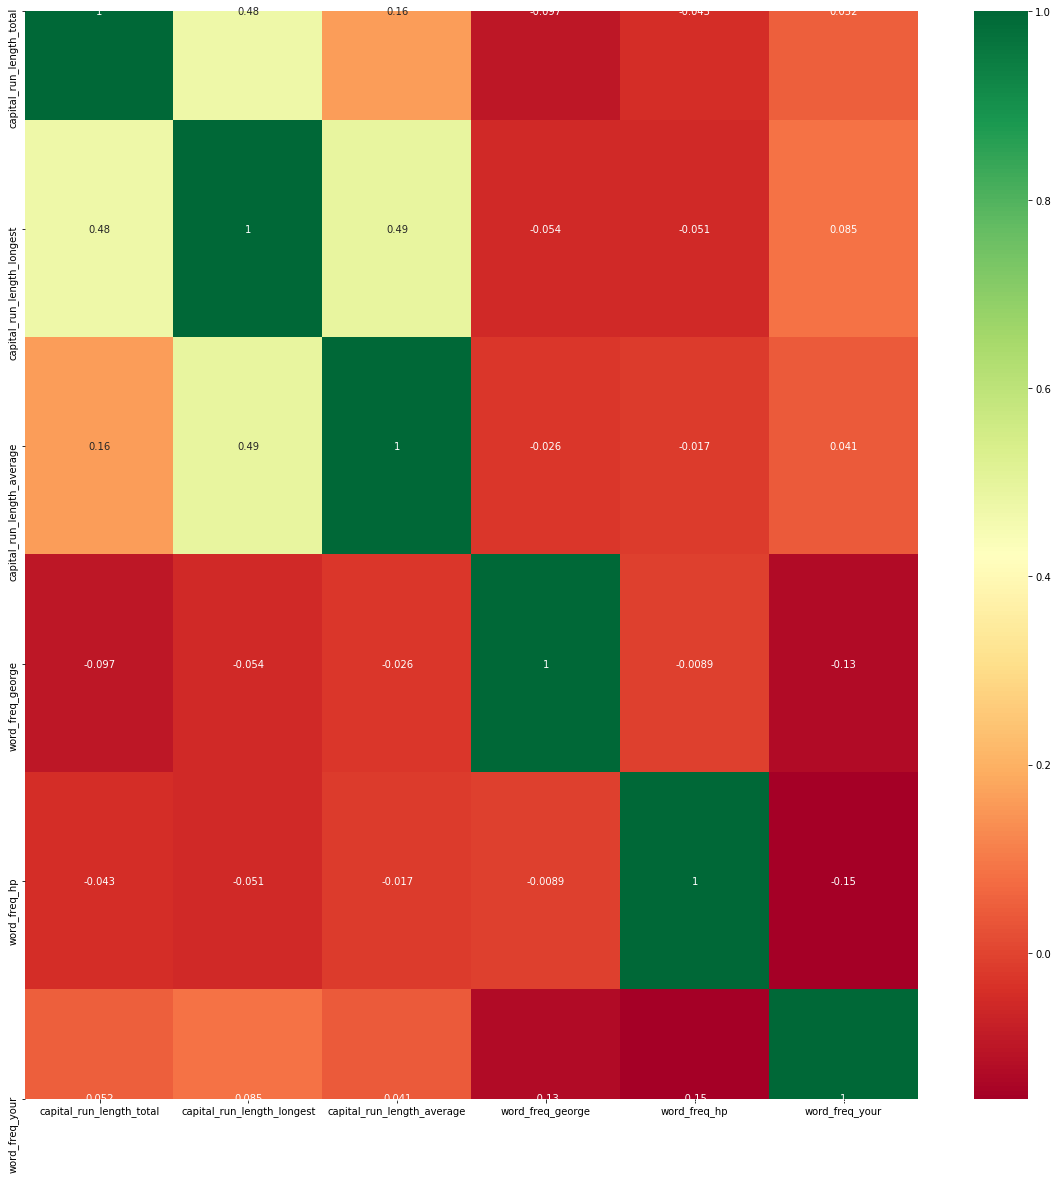

In [10]:
# PART 2D: Is naïve bayes interpretable ? Which words are more important for spam/ham classification? 
# Provide a visual feature analysis of your model performance.

data = email_data[best_features]
X = new_X_test  # Independent features
y = y_train    # Target column
# Get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
# Plot heat map
g=sb.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

print("As you can see, naive bayes is interpretable because when plotting the heat map,\n"
      "you can see some features are more correlated with the label than others. For example, \n"
      "cap len total, cap len longest, and cap len average, are highly correlated with our dataset.\n"
      "Dark red indicates a correlation with ham, whereas, green indicates a correlation w/ spam.")


In [11]:
# PART 2E: Output a confusion matrix from the constructed tree on the test set. 
# Compute accuracy, precision, recall and obtain an AUC plot of the classifier. You can reuse 
# any library but you have to output the data in a way that the plotting function can be invoked. 

# Calculate precision, accuracy, and misclassification rate
trues = (true_positives + true_negatives)
falses = (false_positives + false_negatives)
accuracy = trues / (trues + falses)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
matrix_top = [true_positives, false_positives]
matrix_bot = [false_negatives, true_negatives]
print("Accuracy %.2f%%" %(accuracy*100))
print("Precision %.2f%%" %(precision*100))
print("Recall %.2f%%" %(recall*100))
print("Confusion Matrix:")
print(matrix_top)
print(matrix_bot)

Accuracy 71.76%
Precision 67.86%
Recall 52.78%
Confusion Matrix:
[285, 135]
[255, 706]


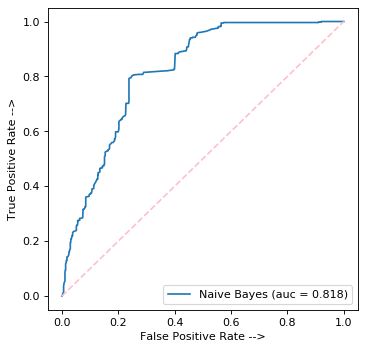

In [12]:
# Calculate y predictions with their scores
y = np.array(y_pred)
np_matrix = np.array(prob_matrix)
scores = np_matrix[:,1]

# Get roc curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)

# Calculate the AUC plot for both models as specificity and 1 - sensitivity
my_auc = auc(fpr, tpr)
# Plot a figure with the AUC for Naive Bayes and Logistic Regression
plt.figure(figsize=(5, 5), dpi=80)
plt.plot(fpr, tpr, linestyle='-', label='Naive Bayes (auc = %0.3f)' % my_auc)

plt.plot([0, 1], [0, 1], color='pink', linestyle='--')

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

In [13]:
# CITATIONS:

# On part 2b for the selectkbest and on part 2d when plotting 
# the heat map, I cite code from Raheel Shaikh at this article
# https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e